# Hello Image Segmentation

A very basic introduction to using segmentation models with OpenVINO™.

In this tutorial, a pre-trained [road-segmentation-adas-0001](https://docs.openvino.ai/2024/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.


#### Table of contents:

- [Imports](#Imports)
- [Download model weights](#Download-model-weights)
- [Select inference device](#Select-inference-device)
- [Load the Model](#Load-the-Model)
- [Load an Image](#Load-an-Image)
- [Do Inference](#Do-Inference)
- [Prepare Data for Visualization](#Prepare-Data-for-Visualization)
- [Visualize data](#Visualize-data)



In [1]:
import platform

# Install required packages
%pip install -q "openvino>=2023.1.0" opencv-python tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import segmentation_map_to_image, download_file

## Download model weights
[back to top ⬆️](#Table-of-contents:)


In [3]:
from pathlib import Path

base_model_dir = Path("./model").expanduser()

model_name = "road-segmentation-adas-0001"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_model_dir / model_xml_name

if not model_xml_path.exists():
    model_xml_url = (
        "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml"
    )
    model_bin_url = (
        "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin"
    )

    download_file(model_xml_url, model_xml_name, base_model_dir)
    download_file(model_bin_url, model_bin_name, base_model_dir)
else:
    print(f"{model_name} already downloaded to {base_model_dir}")

road-segmentation-adas-0001 already downloaded to model


## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [4]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Load the Model
[back to top ⬆️](#Table-of-contents:)


In [5]:
core = ov.Core()

model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

## Load an Image
[back to top ⬆️](#Table-of-contents:)
A sample image from the [Mapillary Vistas](https://www.mapillary.com/dataset/vistas) dataset is provided. 

data/standard-road-line-markings.jpg__1920x0_q100_subsampling-2_upscale.jpg:   0%|          | 0.00/906k [00:00…

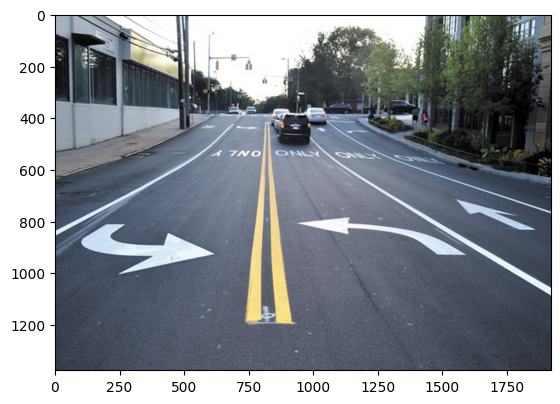

In [6]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://www.mercurynews.com/wp-content/uploads/2016/08/20151001__spdn0929corridor1.jpg",
    directory="data",
)
# https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg

# Other photos for comparison:
# https://static.epermittest.com/media/filer_public_thumbnails/filer_public/31/0a/310aca0e-99c1-42ee-a6e5-918e70411a27/standard-road-line-markings.jpg__1920x0_q100_subsampling-2_upscale.jpg
# https://i.ytimg.com/vi/7ONXSioRpwA/maxresdefault.jpg
# https://www.mercurynews.com/wp-content/uploads/2016/08/20151001__spdn0929corridor1.jpg
# https://di-uploads-pod1.dealerinspire.com/fisherhonda/uploads/2018/11/Snowy-Mountain-Road_82192066.jpg
# https://i.ytimg.com/vi/9a1Ska3xFyM/maxresdefault.jpg
# https://i.ytimg.com/vi/_b3YBWixp_s/maxresdefault.jpg
# https://i.ytimg.com/vi/vPg9yGTFUmQ/maxresdefault.jpg
# https://www.westend61.de/images/0001178279pw/sultanate-of-oman-ras-al-hadd-desert-road-in-a-sand-storm-WVF01126.jpg

# The segmentation network expects images in BGR format.
image = cv2.imread(str(image_filename))

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
plt.imshow(rgb_image)

## Do Inference
[back to top ⬆️](#Table-of-contents:)


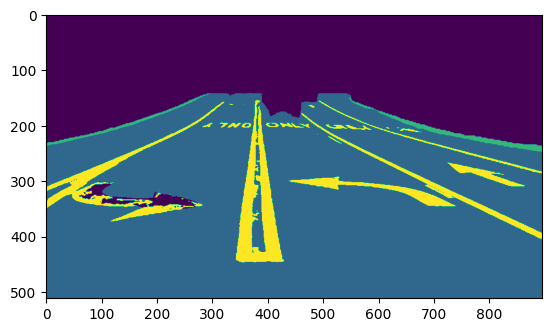

In [7]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
segmentation_mask = np.argmax(result, axis=1)
plt.imshow(segmentation_mask.transpose(1, 2, 0))

## Prepare Data for Visualization
[back to top ⬆️](#Table-of-contents:)


In [8]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image.
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create an image with mask.
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

## Visualize data
[back to top ⬆️](#Table-of-contents:)


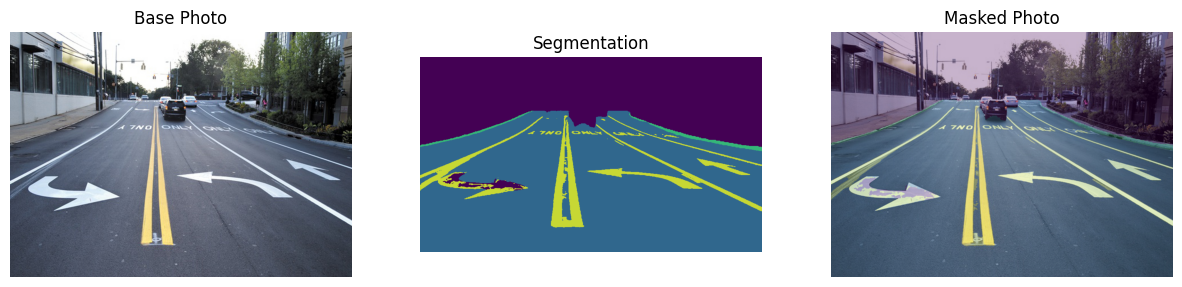

In [9]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis("off")
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)